# Support Vector Machine (SVM)

**Support Vector Machine (SVM)** เป็น supervised machine learning algorithm ที่ทำได้ทั้งการจำแนกหมวดหมู่ (classification) และ การทำนายค่า (regression) โดยใน tutorial นี้ เราจะแสดงการทำงานของโมเดลกับโจทย์การจำแนกหมวดหมู่

<iframe width="560" height="315" src="https://www.youtube.com/embed/Xjpx4TAyjRg?si=E3Uu3Ha6xa5Wv0Q4" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

[Slides: Support Vector Machine (SVM)](https://github.com/ichatnun/brainCodeCamp2023_lectures/blob/main/MachineLearning/machine_learning_svm.pdf)

<br>

หลักการทำงานของ SVM คือ การค้นหา decision boundary ที่สามารถแยกกลุ่มข้อมูลออกจากกันโดยมีค่า margin สูงสุด ดังแสดงในรูปด้านล่าง

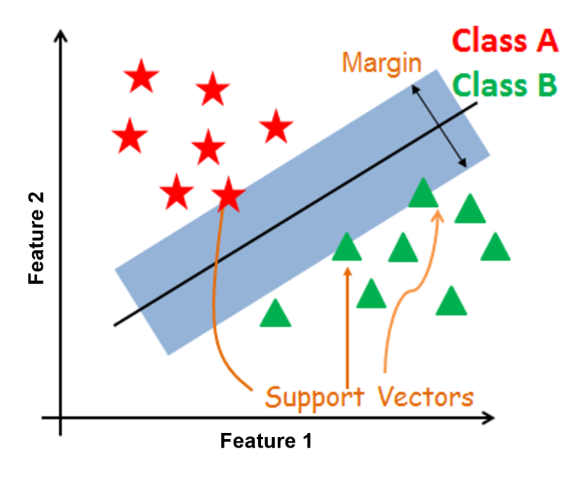

SVM algorithm, adapted from [ที่มา](https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python)

## Functional Margin, Separating Hyperplane และ Support Vectors

เพื่อศึกษาการทำงานของ SVM เราจะลองสร้างชุดข้อมูลที่ประกอบไปด้วยข้อมูลจำนวน $200$ จุด ที่ประกอบด้วย 2 features และ 2 classes ได้แก่ class 0 และ class 1 (2-class dataset for binary classification)  โดยข้อมูลในแต่ละคลาสมีจำนวนเท่ากันที่ 100 จุด

เราจะเรียนรู้การทำ Support Vector Classification ผ่านการเรียกใช้ [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) จากไลบรารี่ `scikit-learn`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# ตั้งค่า random seed สำหรับการทำซ้ำ (reproducibility)
RANDOM_SEED = 2566

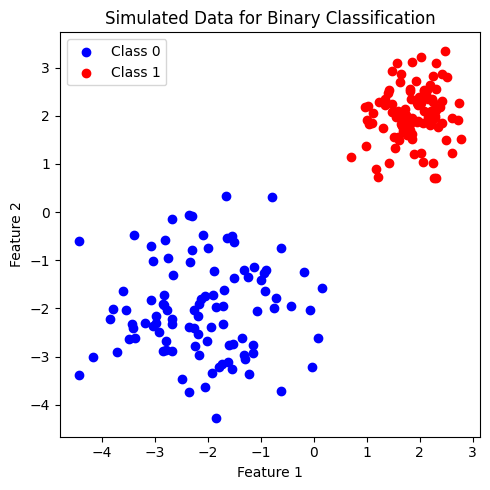

In [2]:
def generate_multi_class_dataset(n_classes, mean_class, std_class, n_samples):
    # สร้างชุดข้อมูลแบบ multi-class
    # ตั้งค่า random seed เพื่อให้สามารถสร้างชุดข้อมูลเดิมทุกครั้ง เพื่อใช้สำหรับการสอน
    np.random.seed(RANDOM_SEED)

    # กำหนด จำนวน features
    n_features = 2

    #  สร้างข้อมูล x สำหรับแต่ละคลาส
    x_data = []
    for label in range(n_classes):
        _ = np.random.normal(mean_class[label], std_class[label], (n_samples, n_features))
        x_data.append(_)

    # สร้างข้อมูล y หรือ labels สำหรับแต่ละคลาส
    y_data = []
    y_data.append(np.zeros(n_samples))
    for label in range(1, n_classes):
        y_data.append(label*np.ones(n_samples))

    # รวมข้อมูล x และ y จากทุกคลาส
    x = np.vstack((x_data))
    y = np.hstack(y_data)

    return x, y

# ทดลองสร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 2

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,-2], [2,2]]
std_class  = [[1,1], [0.5,0.5]]

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 100

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่มีอยู่
plt.figure(figsize = (5,5))
plt.scatter(x[y==0, 0], x[y==0, 1], c='b', label='Class 0')
plt.scatter(x[y==1, 0], x[y==1, 1], c='r', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated Data for Binary Classification')
plt.legend()
plt.tight_layout()
plt.show()

สังเกตว่า ชุดข้อมูลที่สร้างขึ้นมีการกระจายของข้อมูลในแต่ละคลาสแยกกันอย่างชัดเจน  สมมติว่า เราเป็น SVM ที่ต้องการสร้าง decision boundary ที่เป็นเส้นตรง เพื่อเป็นเงื่อนไขในการแบ่งคลาส จะทำได้หรือไม่

จะเห็นได้ว่า เราสามารถขีดเส้นตรงเป็นจำนวนมากที่สามารถจำแนกคลาสได้ (*แสดงในวิดีโอ*) แล้ว SVM จะเลือกเส้นตรงเส้นไหน ด้วยเหตุผลอะไร

เส้นแบ่งคลาส ของ SVM มีชื่อเรียกเฉพาะว่า **separating hyperplane** ทั้งนี้ เราสามารถมอง hyperplane เป็น space เชิงเส้นในหลายมิติ เช่น ใน 2D feature space นั้น hyperplane คือ เส้นตรง ส่วนใน 3D feature space นั้น hyperplane คือ ระนาบ เป็นต้น

<!-- เส้นแบ่งคลาส ของ SVM มีชื่อเรียกเฉพาะว่า **separating hyperplane** ทั้งนี้ hyperplane หมายถึง พื้นที่ย่อยของหนึ่งมิติที่น้อยกว่าพื้นที่คุณลักษณะดั้งเดิม เช่น ใน 2D feature space นั้น hyperplane คือ เส้นตรง ส่วนใน 3D feature space นั้น hyperplane คือ ระนาบ เป็นต้น -->

เพื่อให้การจำแนกคลาสเป็นไปอย่างแม่นยำและมีประสิทธิภาพสูง SVM ไม่เพียงแต่ค้นหา separating hyperplane ที่สามารถจำแนกคลาสของข้อมูลเท่านั้น แต่ยัง maximize ขนาด **functional margin** ซึ่งเป็นระยะห่างระหว่าง separating hyperplane กับจุดข้อมูลที่ใกล้เคียงที่สุดจากแต่ละคลาส ซึ่งมักจะเป็นจุดข้อมูลที่จำแนกได้ยากที่สุด จึงเป็นเงื่อนไขสำคัญสำหรับ SVM ที่จะตัดสินใจ จุดข้อมูลเหล่านี้มีชื่อเรียกเฉพาะว่า **support vectors** ดังตัวอย่างด้านล่าง

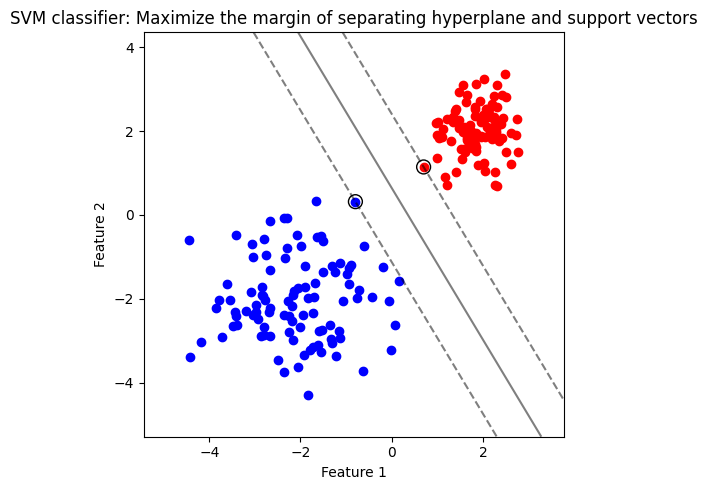

In [3]:
# สร้างโมเดล
clf = SVC(kernel='linear', random_state=RANDOM_SEED)

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
clf.fit(x, y)

# Plot ข้อมูล x, y
plt.figure(figsize = (5,5))
plt.scatter(x[y==0, 0], x[y==0, 1], c='b', label='Class 0')
plt.scatter(x[y==1, 0], x[y==1, 1], c='r', label='Class 0')

# plot the decision function
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(clf,
                                       x,
                                       plot_method="contour",
                                       colors="k",
                                       levels=[-1, 0, 1],
                                       alpha=0.5,
                                       linestyles=["--", "-", "--"],
                                       ax=ax)

# plot support vectors
ax.scatter(clf.support_vectors_[:, 0],
           clf.support_vectors_[:, 1],
           s=100, linewidth=1,
           facecolors='none',
           edgecolors='k'
           )
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM classifier: Maximize the margin of separating hyperplane and support vectors')
plt.tight_layout()
plt.show()

รูปแสดง separating hyperplane (เส้นทึบ) ที่มี margin สูงสุด (ระยะห่างระหว่างเส้นประ) จาก support vectors (จุดข้อมูลในวงกลม) เมื่อใช้ linear kernel

เราสามารถใช้ SVM ในการจำแนก class 0 และ class 1 อย่างง่ายโดยใช้ `linear kernel` ซึ่ง โมเดลจะสร้าง decision boundary ที่เป็นเส้นตรง เพื่อเป็นเงื่อนไขในการจำแนกคลาส  ทั้งนี้ SVM มีการทำงานร่วมกับ `kernel` ประเภทอื่นๆ ที่สามารถแปลง feature space ของชุดข้อมูลเริ่มต้นให้มีมิติสูงขึ้น ทำให้ SVM สามารถจำแนกกลุ่มข้อมูลที่มีความซับซ้อนได้มีประสิทธิภาพ

## SVM เมื่อใช้ `kernel` ประเภทต่างๆ

Kernel ถูกนำมาใช้เพื่อเพิ่มความสามารถในการจำแนกชุดข้อมูลที่มีความซับซ้อนมากขึ้น โดยเพิ่มความสามารถในการสร้าง decision boundary ที่มีลักษณะไม่เป็นเชิงเส้น นอกจากนี้ บาง kernel  ยังสามารถแปลง features ของชุดข้อมูลไปสู่มิติที่สูงขึ้น โดย kernel อยู่ในรูปฟังก์ชันต่างๆ เช่น

- Linear kernel: ที่เราใช้ก่อนหน้านี้ เป็นการแยกกลุ่มข้อมูลด้วยเส้นตรงในมิติต้นฉบับ

- Polynomial kernel: ใช้สำหรับการแยกกลุ่มข้อมูลที่ด้วยเส้น polynomial ในมิติต้นฉบับ เมื่อใช้ polynomial kernel เราต้องกำหนด `degree` ของ polynomial ซึ่งตัว polynomial kernel จะใช้ได้ดีเมื่อ features ของข้อมูลของเรามีปฏิสัมพันธ์กัน

- Radial Basis Function (RBF) kernel: เป็น kernel ที่ถูกใช้งานมากและเป็นที่นิยม ]เนื่องจากสามารถจำแนกกลุ่มข้อมูลที่มีลักษณะซับซ้อนได้ดี โดยแปลงข้อมูล features ไปสู่มิติที่สูงขึ้น  ทั้งนี้ RBF ยังเป็น default kernel ของ `scikit-learn` ในการทำ Support Vector Classification การใช้ RBF kernel จะใช้ได้ค่อนข้างดีในสถานการณ์ที่เรามี training data จำนวนมาก

เราสามารถเลือกใช้ `kernel` ตามลักษณะของข้อมูลและงานที่ต้องการ
ดังตัวอย่างด้านล่าง ทั้งนี้ เราจะสร้างข้อมูลชุดเดียวกับที่ใช้ก่อนหน้านี้ใน tutorial ของ logistic regression

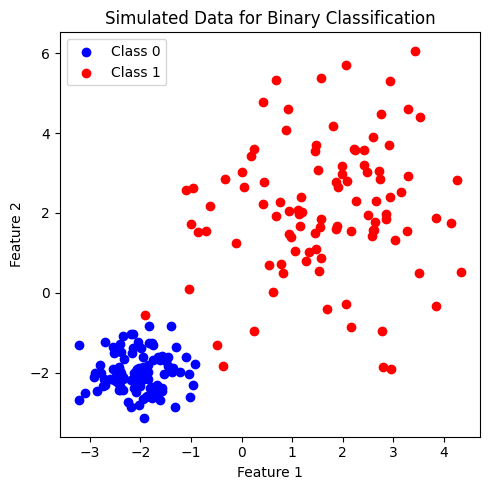

In [4]:
# ทดลองสร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 2

# กำหนดช่วงค่า Mean และ standard deviation (SD) สำหรับแต่ละคลาส
# เนื่องจากเรากำหนดจำนวน features เป็น 2 จึงสามารถกำหนด Mean และ SD ด้วย array ของ 2 ค่า
mean_class = [[-2,-2], [2,2]]
std_class  = [[0.5,0.5], [1.5,1.5]]

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 100

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class, n_samples)

# Plot ข้อมูล x, y ที่มีอยู่
plt.figure(figsize = (5,5))
plt.scatter(x[y==0, 0], x[y==0, 1], c='b', label='Class 0')
plt.scatter(x[y==1, 0], x[y==1, 1], c='r', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated Data for Binary Classification')
plt.legend()
plt.tight_layout()
plt.show()

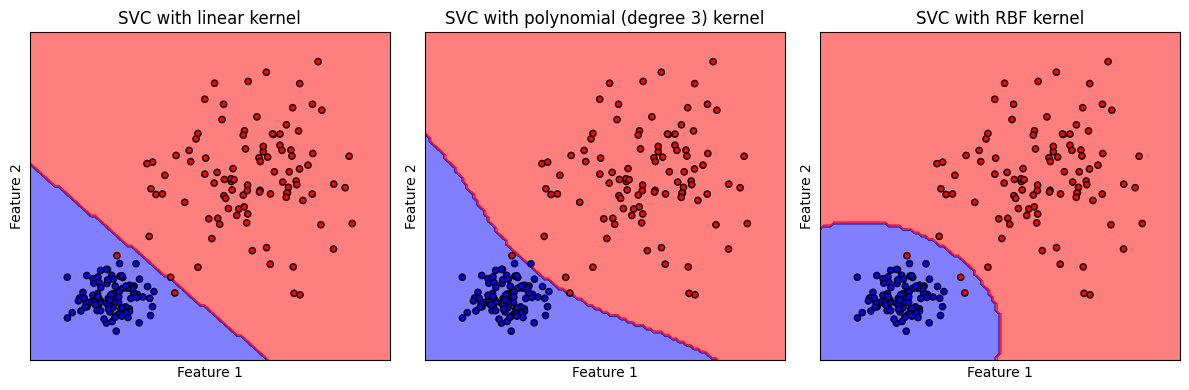

In [5]:
# สร้างชุดโมเดล
models = (SVC(kernel='linear', random_state=RANDOM_SEED),
          SVC(kernel='poly', degree=3, random_state=RANDOM_SEED),
          SVC(kernel='rbf', random_state=RANDOM_SEED),
          )

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
models = (clf.fit(x, y) for clf in models)

# สร้าง cmap สำหรับแสดงผลตามสีแต่ละ class
cmap_2classes = colors.ListedColormap(['b', 'r'])

# ตั้งชื่อ plot ที่สอดคล้องกับชุดข้อมูล
titles = ['SVC with linear kernel',
          'SVC with polynomial (degree 3) kernel',
          'SVC with RBF kernel',
          ]

# plot the decision boundaries
fig, axes = plt.subplots(1,3, figsize=(12, 4))
for clf, title, ax in zip(models, titles, axes.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(clf,
                                                  x,
                                                  response_method="predict",
                                                  cmap=cmap_2classes,
                                                  alpha=0.5,
                                                  ax=ax,
                                                  xlabel='Feature 1',
                                                  ylabel='Feature 2',
                                                  )
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap_2classes, s=20, edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.tight_layout()
plt.show()

รูปแสดง decision boundary ของ SVM classifier ที่ใช้ linear kernel, polynomial (degree 3) kernel และ RBF kernel

จะสังเกตได้ว่า โมเดลที่ใช้ linear kernel สร้าง decision boundary ที่มีลักษณะเชิงเส้น คล้ายคลึงกับที่พบจากโมเดล logistic  ในขณะที่ polynomial (degree 3) kernel และ RBF kernel สร้าง decision boundary ที่มีลักษณะไม่เป็นเชิงเส้น

ต่อไปเราจะลองสร้างชุดข้อมูลที่มีความซับซ้อนมากขึ้น และเปรียบเทียบการทำงานของ SVM เมื่อใช้ kernel ประเภทต่างๆ

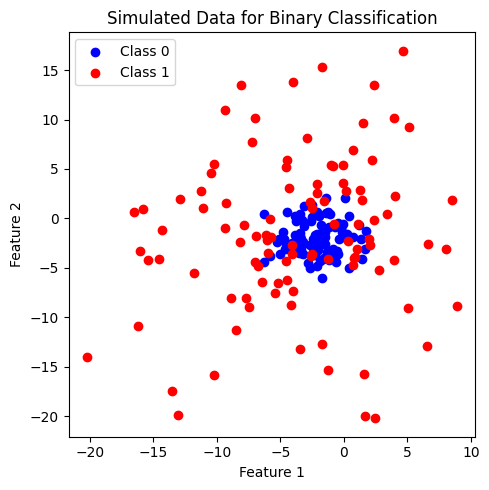

In [6]:
# ทดลองสร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 2

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,-2], [-2,-2]]
std_class  = [[1.75,1.75], [7,7]]

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 100

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่มีอยู่
plt.figure(figsize = (5,5))
plt.scatter(x[y==0, 0], x[y==0, 1], c='b', label='Class 0')
plt.scatter(x[y==1, 0], x[y==1, 1], c='r', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated Data for Binary Classification')
plt.legend()
plt.tight_layout()
plt.show()

ข้อมูลที่สร้างขึ้นมีประกอบด้วย 2 features และ 2 classes (class: 0, 1) โดยข้อมูลในแต่ละคลาสมีจำนวนเท่ากันที่ 100 จุด เมื่อพิจารณาการกระจายตัวของข้อมูล พบว่า ข้อมูลคลาส 0 จะรวมตัวกัน โดยมีข้อมูลคลาส 1 กระจายตัวอยู่โดยรอบ  เราจะลองใช้ SVM และ kernel ที่ได้เรียนรู้ก่อนหน้านี้มาจำแนกข้อมูลชุดนี้

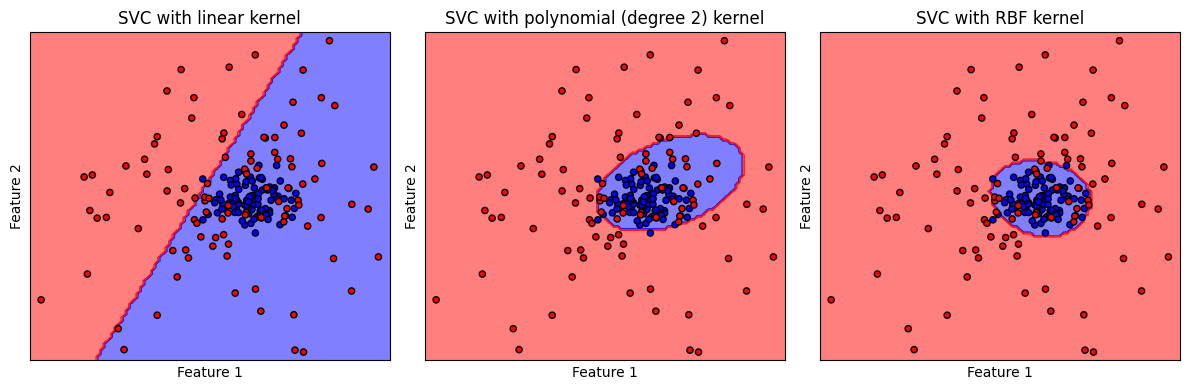

In [7]:
# สร้างชุดโมเดล
models = (SVC(kernel='linear', random_state=RANDOM_SEED),
          SVC(kernel='poly', degree=2, random_state=RANDOM_SEED),
          SVC(kernel='rbf', random_state=RANDOM_SEED),
          )

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
models = (clf.fit(x, y) for clf in models)

# ตั้งชื่อ plot ที่สอดคล้องกับชุดข้อมูล
titles = ['SVC with linear kernel',
          'SVC with polynomial (degree 2) kernel',
          'SVC with RBF kernel',
          ]

# plot the decision boundaries
fig, axes = plt.subplots(1,3, figsize=(12, 4))
for clf, title, ax in zip(models, titles, axes.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(clf,
                                                  x,
                                                  response_method="predict",
                                                  cmap=cmap_2classes,
                                                  alpha=0.5,
                                                  ax=ax,
                                                  xlabel='Feature 1',
                                                  ylabel='Feature 2',
                                                  )
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap_2classes, s=20, edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.tight_layout()
plt.show()

จะเห็นได้ว่า ข้อมูลชุดนี้ไม่เหมาะกับการใช้ linear kernel โดย พบว่า polynomial (degree 2) kernel และ RBF kernel สร้าง non-linear decision boundary ที่มีความเหมาะสมกับการจำแนกชุดข้อมูลมากกว่า

## SVM เมื่อใช้ร่วมกับ Regularization

เมื่อใช้งาน SVM ร่วมกับ kernel ที่สามารถแปลง feature space ของชุดข้อมูลเริ่มต้นให้มีมิติสูงขึ้น ทำให้ SVM สามารถจำแนกกลุ่มข้อมูลที่มีความซับซ้อนได้แม่นยำขึ้น แต่ในขณะเดียวกัน ก็ส่งผลให้สามารถเกิด overfitting ได้ง่าย  เพื่อลดปัญหานี้ เราสามารถใช้งาน SVM ร่วมกับ regularization โดยในไลบรารี่ `scikit-learn` เราสามารถปรับค่า regularization strength ผ่านทางไฮเปอร์พารามิเตอร์ `C` ดังสมการ

$$
C \sum_{i=1}^{n} L(f(x_i),y_i) + Ω(w)
$$

เมื่อ $L$ คือ loss function มาตรฐานของ SVM ซึ่งเป็นพจน์ที่พยายามทำให้โมเดลให้คำตอบที่ถูกต้องสำหรับจุดข้อมูลใน training data, $w$ แสดงถึงพารามิเตอร์ของโมเดล และ $Ω(w)$ คือ regularization term โดยเป็นการเรียกใช้ L2 regularization


* การกำหนดให้ $C$ มีค่าน้อย เป็นการลดความสำคัญของ $L$ ส่งผลให้โมเดลโฟกัสกับ regularization term มากขึ้น ดังนั้นโมเดลจึงไม่ได้พยายามเรียนรู้จาก training data ที่มีอยู่มากนัก ซึ่งช่วยป้องกันปัญหา overfitting


* การเพิ่มค่า $C$ ให้มากขึ้น เป็นการเพิ่มน้ำหนักให้กับ $L$ ส่งผลให้โมเดลสามารถเรียนรู้จาก training data ได้มากขึ้น
  * ถ้าหากเราเพิ่มค่า $C$ จนมากเกินไป โมเดลจะโฟกัสกับ $L$ มากขึ้นเรื่อย ๆ จนไม่ค่อยสนใจ regularization term ทำให้มีโอกาสที่จะเจอปัญหา overfitting ในกรณีที่โมเดลเรามีจำนวนพารามิเตอร์เมื่อเทียบกับจำนวนข้อมูลได้


(ข้อมูลเพิ่มเติม [Scaling the regularization parameter for SVCs](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_scale_c.html))

เรามาลองดู decision boundary ว่าจะมีลักษณะเป็นอย่างไรเมื่อเราใช้เทคนิค regularization ด้วยค่า $C$ หลาย ๆ ค่ากัน

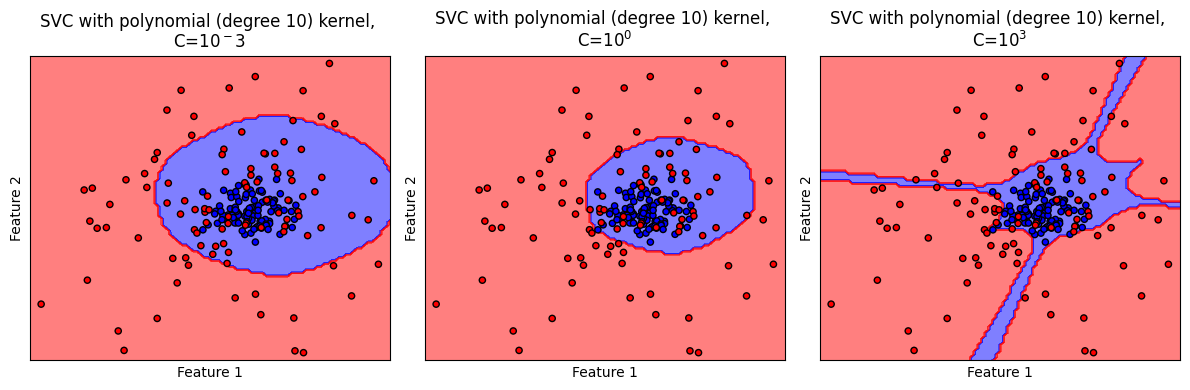

In [8]:
# สร้างชุดโมเดล
models = (SVC(kernel='poly', degree=10, random_state=RANDOM_SEED, C=0.001),
          SVC(kernel='poly', degree=10, random_state=RANDOM_SEED, C=1),
          SVC(kernel='poly', degree=10, random_state=RANDOM_SEED, C=10000)
          )

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
models = (clf.fit(x, y) for clf in models)

# ตั้งชื่อ plot ที่สอดคล้องกับชุดข้อมูล
titles = ['SVC with polynomial (degree 10) kernel, \nC=$10^-3$',
          'SVC with polynomial (degree 10) kernel, \nC=$10^0$',
          'SVC with polynomial (degree 10) kernel, \nC=$10^3$'
          ]

# plot the decision boundaries
fig, axes = plt.subplots(1,3, figsize=(12, 4))
for clf, title, ax in zip(models, titles, axes.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(clf,
                                                  x,
                                                  response_method="predict",
                                                  cmap=cmap_2classes,
                                                  alpha=0.5,
                                                  ax=ax,
                                                  xlabel='Feature 1',
                                                  ylabel='Feature 2',
                                                  )
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap_2classes, s=20, edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.tight_layout()
plt.show()

ตัวอย่างนี้แสดงให้เห็นของปัญหาที่เกิดขึ้นเมื่อเราใช้ค่า `C` ที่มีค่ามากจนเกินพอดี ส่งผลให้เกิด decision boundary ที่มีความซับซ้อนเกิดกว่าสิ่งที่ควรจะเป็น (overfitting)

## SVM Pipeline

ต่อไปเราจะลองพัฒนาโมเดล SVM อย่างครบกระบวนการ ด้วยชุดข้อมูลที่จะสร้างขึ้น

### Generate 3-class dataset

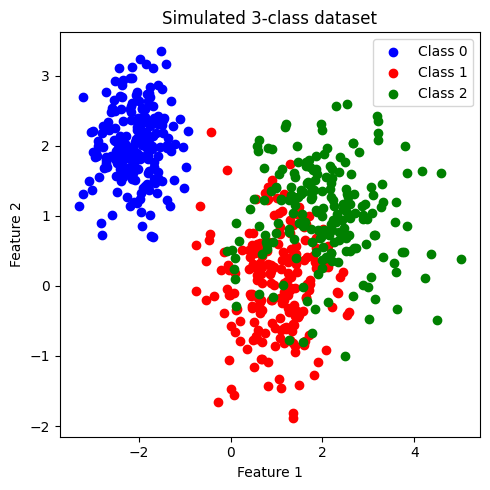

In [9]:
# สร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 3

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,2], [1,0], [2,1]]#[[-2,2], [0,0], [2,2]]
std_class  = [[0.5,0.5], [0.75,0.75],[1,0.75]]#[[1,0.75], [1,0.75],[1,0.75]] #[[0.75,0.5], [0.5,1],[0.5,0.75]]

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 200

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่สร้างขึ้น
plt.figure(figsize = (5,5))
color_list = ['b','r','g']
cmap_3classes = colors.ListedColormap(color_list)
for label in range(n_classes):
    plt.scatter(x[y==label, 0], x[y==label, 1], c=color_list[label], label='Class '+str(label))

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated 3-class dataset')
plt.legend()
plt.tight_layout()
plt.show()


ข้อมูลที่สร้างขึ้นมีประกอบด้วย 2 features และ 3 classes (class: 0, 1, 2) โดยข้อมูลในแต่ละคลาสมีจำนวนเท่ากันที่ 200 จุด   เราจะพัฒนาโมเดล SVM เพื่อจำแนกข้อมูลแต่ละคลาสออกจากกัน

เมื่อสังเกตการกระจายตัวของข้อมูล พบว่า class 0 มีการกระจายข้อมูลแบ่งแยกออกมาอย่างเห็นได้ชัด ในขณะที่ class 1 และ class 2 จะกระจายตัวอยู่ร่วมกัน

### แบ่งข้อมูลเป็น training data และ test data

โดยใช้ [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) จากไลบรารี่ `scikit-learn`

ในตัวอย่างนี้เราจะใช้ default value ซึ่งจะ shuffle ข้อมูลก่อนแบ่งข้อมูล และ ไม่ stratify (ไม่กำกับสัดส่วนของคลาสใน training data และ test data)

อย่างไรก็ดี ในกรณีที่ข้อมูลประกอบด้วยคลาสต่างๆ ที่มีสัดส่วนต่างกันอย่างมาก (imbalanced dataset) การทำ stratify มีความจำเป็นอย่างมากเพื่อคงสัดส่วนของแต่ละคลาส ใน training data และ test data

In [10]:
# สร้าง training data และ test data โดยแบ่งจากชุดข้อมูล x,y
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    stratify=None, random_state=RANDOM_SEED)

print('Train set: จำนวนข้อมูล แบ่งกลุ่มตาม class label')
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

print('Test set: จำนวนข้อมูล แบ่งกลุ่มตาม class label')
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

Train set: จำนวนข้อมูล แบ่งกลุ่มตาม class label
[[  0. 169.]
 [  1. 155.]
 [  2. 156.]]
Test set: จำนวนข้อมูล แบ่งกลุ่มตาม class label
[[ 0. 31.]
 [ 1. 45.]
 [ 2. 44.]]


### ทำการ standardize ข้อมูลทั้งหมด
ใช้ mean และ standard deviation (SD) จาก training data ในการ standardize test set เพื่อป้องกัน information leak

In [11]:
# สร้าง standardized scaler จาก features ใน training data
x_scaler = StandardScaler().fit(x_train)

# scale ค่า features ใน training data และ test data
x_train = x_scaler.transform(x_train)
x_test  = x_scaler.transform(x_test)

### เทรนโมเดล ด้วย base model (default hyperparameter)

Training Set: Classification report
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       169
         1.0       0.82      0.85      0.83       155
         2.0       0.85      0.81      0.83       156

    accuracy                           0.89       480
   macro avg       0.89      0.89      0.89       480
weighted avg       0.89      0.89      0.89       480


Test Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        31
         1.0       0.82      0.91      0.86        45
         2.0       0.90      0.80      0.84        44

    accuracy                           0.89       120
   macro avg       0.91      0.90      0.90       120
weighted avg       0.89      0.89      0.89       120



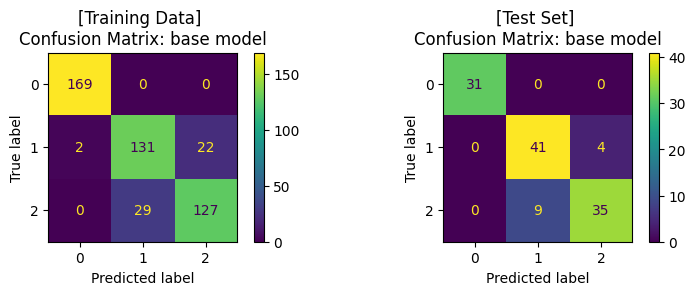

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# สร้างโมเดล
base_clf = SVC(random_state=RANDOM_SEED)

# สอนโมเดลด้วย training data
base_clf.fit(x_train,y_train)

# ให้โมเดลทำนาย training data
y_pred = base_clf.predict(x_train)

# แสดงผล classification ของโมเดลจาก training data
print('Training Set: Classification report')
print(classification_report(y_train, y_pred))

# คำนวนและแสดงผล confusion matrix ของ training data
cm = confusion_matrix(y_train, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax1)
ax1.set_title('[Training Data] \nConfusion Matrix: base model')

# ให้โมเดลทำนาย test data
y_pred = base_clf.predict(x_test)

# แสดงผล classification ของโมเดล
print('\nTest Set: Classification report')
print(classification_report(y_test, y_pred))

# คำนวนและแสดงผล confusion matrix ของ test set
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax2)
ax2.set_title('[Test Set] \nConfusion Matrix: base model')

plt.tight_layout()
plt.show()

### ปรับแต่งโมเดล (Hyperparameter Tuning) ด้วย [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) และ train โมเดล

โดยเราจะปรับแต่งโมเดล โดย tune 2 hyperparameters ที่สำคัญของ SVM ได้แก่
1. `kernel`
2. `C`

ในไลบรารี่ `scikit-learn` ยังมีวิธีการอื่นๆ ในการปรับแต่งโมเดล เช่น
- [CrossValScore](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score)
- [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)



Best hyperparameters: {'C': 10, 'kernel': 'rbf'}
Best cross-validation score: 0.89
Training Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       169
         1.0       0.82      0.90      0.86       155
         2.0       0.89      0.81      0.85       156

    accuracy                           0.91       480
   macro avg       0.91      0.90      0.90       480
weighted avg       0.91      0.91      0.91       480


Test Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        31
         1.0       0.83      0.96      0.89        45
         2.0       0.95      0.80      0.86        44

    accuracy                           0.91       120
   macro avg       0.92      0.92      0.92       120
weighted avg       0.92      0.91      0.91       120



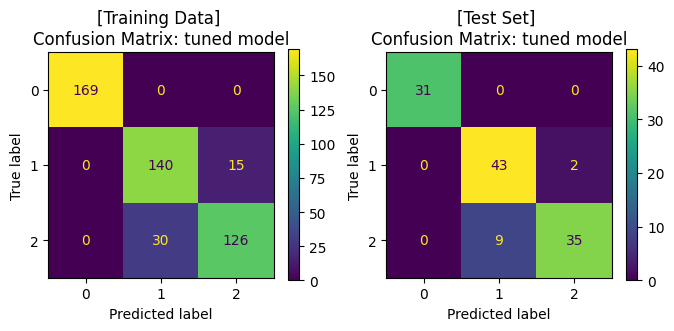

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# กำหนดช่วงค่า hyperparameters ในรูปแบบ dictionary
clf_params = {'kernel': ['rbf','linear'],
              'C': [0.01, 0.1, 1, 10, 100, 1000]
              }

# แบ่งข้อมูล training data ด้วย 5-fold cross-validation เพื่อ tune hyperparameter
cv_splitter = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# ใช้ GridSearchCV เพื่อสอนโมเดลจากชุดค่า hyperparameters จาก clf_params
# และคำนวณค่า accuracy ของแต่ละโมเดล เพื่อเลือกชุด hyperparameters ที่ดีที่สุด
# โดยใช้เทคนิค cross-validation ในการแบ่งกลุ่ม validation data จาก training data
tuned_clf = GridSearchCV(estimator=base_clf, param_grid=clf_params,
                             scoring=['accuracy'], refit='accuracy', cv=cv_splitter)

# fit โมเดลด้วย training data และ ให้โมเดลทำนายค่า y จาก training data
tuned_clf.fit(x_train, y_train)
y_pred = tuned_clf.predict(x_train)

# แสดงผล hyperparameters ที่ดีที่สุด และ cross-validation score
print('Best hyperparameters: {}'.format(tuned_clf.best_params_))
print("Best cross-validation score: {:.2f}".format(tuned_clf.best_score_))

# แสดงผล classification ของโมเดลจาก training data
print('Training Set: Classification report')
print(classification_report(y_train, y_pred))

# คำนวนและแสดงผล confusion matrix ของโมเดลจาก training data
cm = confusion_matrix(y_train, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax1)
ax1.set_title('[Training Data] \nConfusion Matrix: tuned model')

# ให้โมเดลทำนายค่า y จาก test data
y_pred = tuned_clf.predict(x_test)

# แสดงผล classification ของโมเดล จาก test data
print('\nTest Set: Classification report')
print(classification_report(y_test, y_pred))
# คำนวนและแสดงผล confusion matrix จาก test data
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax2)
ax2.set_title('[Test Set] \nConfusion Matrix: tuned model')

plt.show()

จะสังเกตได้ว่า เมื่อมีการปรับจูน hyperparameters ของโมเดลให้มีความเหมาะสมแล้ว เราได้โมเดลที่เรียนรู้จากข้อมูลชุดเดิม แล้วสามารถทำนาย test data ได้ค่า accuracy ที่สูงขึ้น โดยเมื่อพิจารณา Confusion Matrix จะพบว่า โมเดลสามารถจำแนกข้อมูล class 1 และ class 2 ได้ดีขึ้น

### Decision Boundary

เราจะมาลองดู decision boundary ของโมเดลบน training data และ test data

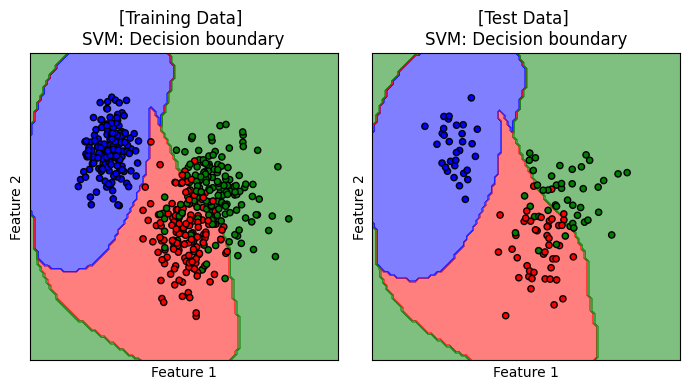

In [14]:
# plot the decision boundaries
fig, axes = plt.subplots(1,2, figsize=(7, 4))
titles = ['[Training Data] \nSVM: Decision boundary', '[Test Data] \nSVM: Decision boundary']
for x, y, title, ax in zip([x_train, x_test], [y_train, y_test], titles, axes.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(tuned_clf,
                                                  x,
                                                  response_method="predict",
                                                  cmap=cmap_3classes,
                                                  alpha=0.5,
                                                  ax=ax,
                                                  xlabel='Feature 1',
                                                  ylabel='Feature 2',
                                                  )
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap_3classes, s=20, edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.tight_layout()
plt.show()

แสดง decision boundary ของ SVM ที่ทำงานร่วมกับ `RBF kernel` เมื่อ `C=10` ซึ่งเป็นโมเดลที่ได้รับการปรับจูนให้เหมาะสมกับการเรียนรู้จากชุดข้อมูลนี้

**ผู้จัดเตรียม code ใน tutorial**: ดร. กนกกร พิมพ์เจริญ